# 04_log

In [2]:
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s  0:00:00


In [6]:
%matplotlib inline

In [16]:
import pandas as pd
from pathlib import Path

# Replace this with your real output file path from the pipeline
inc_path = Path("../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv")  

df = pd.read_csv(inc_path)
df.head(), df.columns

(  state  year  week  cases   rain_mm     temp_c
 0  Abia  2018     1      0  0.029167  27.110085
 1  Abia  2018     2      0  2.389669  28.605963
 2  Abia  2018     3      0  2.002001  29.030485
 3  Abia  2018     4      0  0.611703  28.548828
 4  Abia  2018     5      0  0.249704  30.093192,
 Index(['state', 'year', 'week', 'cases', 'rain_mm', 'temp_c'], dtype='object'))

In [35]:
# ============================================
# 1) Helpers: accept (year, week) OR date
# ============================================
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional for DAG
try:
    import networkx as nx
except ImportError:
    nx = None


@dataclass
class FigConfig:
    outdir: Path = Path("../reports/figures")
    dpi: int = 300
    fmt: str = "png"  # use "pdf" for vector output
    linewidth: float = 2.0
    fontsize: int = 11

    def ensure_outdir(self) -> None:
        self.outdir.mkdir(parents=True, exist_ok=True)


def set_mpl_style(cfg: FigConfig) -> None:
    plt.rcParams.update({
        "figure.dpi": cfg.dpi,
        "savefig.dpi": cfg.dpi,
        "font.size": cfg.fontsize,
        "axes.titlesize": cfg.fontsize + 1,
        "axes.labelsize": cfg.fontsize,
        "legend.fontsize": cfg.fontsize - 1,
        "xtick.labelsize": cfg.fontsize - 1,
        "ytick.labelsize": cfg.fontsize - 1,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "lines.linewidth": cfg.linewidth,
    })


def save_fig(cfg: FigConfig, name: str, show: bool = True) -> Path:
    """
    Saves figure and optionally shows it inline (useful in Jupyter).
    Returns the saved path.
    """
    cfg.ensure_outdir()
    path = cfg.outdir / f"{name}.{cfg.fmt}"
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return path


def ensure_week_date(
    df: pd.DataFrame,
    date_col: Optional[str] = None,
    year_col: str = "year",
    week_col: str = "week",
    out_col: str = "date",
    week_start: int = 1,  # ISO: 1=Mon ... 7=Sun
) -> pd.DataFrame:
    """
    Ensures a datetime weekly index column exists.
    - If date_col is provided and exists, it will be converted to datetime.
    - Else it will construct a week-start date from ISO (year, week).
    """
    d = df.copy()

    if date_col is not None and date_col in d.columns:
        d[out_col] = pd.to_datetime(d[date_col])
        return d

    missing = [c for c in [year_col, week_col] if c not in d.columns]
    if missing:
        raise ValueError(f"Missing required columns for (year, week) conversion: {missing}")

    # ISO week-safe: %G ISO year, %V ISO week, %u weekday (1=Mon..7=Sun)
    iso = (
        d[year_col].astype(int).astype(str)
        + "-W"
        + d[week_col].astype(int).astype(str).str.zfill(2)
        + f"-{int(week_start)}"
    )
    d[out_col] = pd.to_datetime(iso, format="%G-W%V-%u")
    return d


def weekly_caption(note: str = "") -> str:
    """
    Caption snippet to explicitly signal ISO weekly aggregation.
    """
    base = "Weekly time series aggregated by ISO epidemiological week (ISO-8601; week starts Monday)."
    if note:
        return f"{base} {note}"
    return base


# ============================================
# 2) Figure 1: Conceptual pipeline DAG
# ============================================
def fig_pipeline_dag(cfg: FigConfig, name: str = "fig1_pipeline_dag_refs") -> None:
    """
    DAG schematic with automatic numbered citations placed on each arrow.

    Arrow → reference map (numbers shown on edges):
      [1] Climate -> Rodent
      [2] LandUse -> Rodent
      [3] Rodent -> Spillover
      [4] Contact -> Spillover
      [5] Spillover -> H2H
      [6] H2H -> Obs
      [7] Surv -> Obs
      [8] Climate -> Contact
      [8] LandUse -> Contact   (same reference supports both env->exposure links)

    Suggested reference list for [1]–[8] is below the function.
    [1] Fichet-Calvet E, Rogers DJ. Risk maps of Lassa fever in West Africa. PLoS Negl Trop Dis (2009).
    [2] Olayemi A, et al. Systematics, ecology, and host switching of Lassa virus reservoirs (overview of African reservoirs and ecological context). Viruses (2020).
    [3] Plowright RK, et al. Pathways to zoonotic spillover (general spillover framework applicable to Lassa). Nat Rev Microbiol (2017).
    [4] Bonner PC, et al. Poor housing quality increases risk of rodent infestation and Lassa fever (exposure pathway evidence). Am J Trop Med Hyg (2007).
    [5] Ilori EA, Frank C, Dan-Nwafor CC, et al. Increase in Lassa fever cases in Nigeria, Jan–Mar 2018 (primary infections seeding onward spread; response intensification context). Emerg Infect Dis (2019).
    [6] Dan-Nwafor CC, et al. Cluster of nosocomial Lassa fever cases in a tertiary health facility in Nigeria (hospital transmission). Int J Infect Dis (2019).
    [7] Simons D, et al. Lassa fever under-reporting / surveillance gaps (observed cases as a filtered subset of true infections). — (2022; open access on PMC).
    [8] Morse SS, et al. Prediction and prevention of the next pandemic zoonosis (environmental change shaping human exposure and interfaces). The Lancet (2012).
    """
    if nx is None:
        raise ImportError("networkx is required for fig_pipeline_dag. Install with: pip install networkx")

    set_mpl_style(cfg)

    G = nx.DiGraph()

    # Nodes (edit labels as needed)
    nodes = [
        ("Climate", "Climate variability\n(rainfall, temp, humidity)"),
        ("LandUse", "Land use / cover change\n(deforestation, agriculture)"),
        ("Rodent", "Rodent ecology\n(density, infection prevalence)"),
        ("Contact", "Human exposure\n(housing, occupation, food storage)"),
        ("Spillover", "Zoonotic spillover\n(primary infections)"),
        ("H2H", "Human-to-human transmission\n(hospital, household)"),
        ("Surv", "Surveillance / reporting\n(detection probability, delays)"),
        ("Obs", "Observed cases\n(weekly incidence)"),
    ]
    for k, label in nodes:
        G.add_node(k, label=label)

    # Edges with citation numbers
    edges_with_refs = [
        ("Climate", "Rodent", 1),
        ("LandUse", "Rodent", 2),
        ("Rodent", "Spillover", 3),
        ("Contact", "Spillover", 4),
        ("Spillover", "H2H", 5),
        ("H2H", "Obs", 6),
        ("Surv", "Obs", 7),
        ("Climate", "Contact", 8),
        ("LandUse", "Contact", 8),
    ]
    G.add_edges_from([(u, v) for u, v, _ in edges_with_refs])

    # Layout (your original)
    pos = {
        "Climate": (0, 2),
        "LandUse": (0, 1),
        "Rodent": (2, 1.5),
        "Contact": (2, 0.5),
        "Spillover": (4, 1.0),
        "H2H": (6, 1.0),
        "Surv": (6, 0.0),
        "Obs": (8, 0.8),
    }

    plt.figure(figsize=(10.5, 4.2))
    labels = {k: v for k, v in nodes}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2600)

    # Draw edges (slight curvature helps label separation)
    nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=18,
        width=1.8,
        connectionstyle="arc3,rad=0.08",
    )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # ---- Draw edge citation numbers automatically ----
    edge_labels = {(u, v): f"[{refno}]" for u, v, refno in edges_with_refs}

    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.5,
        rotate=False,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.85),
    )

    plt.title("Lassa fever transmission pipeline: conceptual model (numbers map to references)")
    plt.axis("off")
    save_fig(cfg, name)



# ============================================
# 3) Figure 2: Observed-only OR Observed vs Fitted
#    Accepts (year, week) and converts internally.
# ============================================
def fig_observed_only(
    cfg: FigConfig,
    df: pd.DataFrame,
    *,
    date_col: Optional[str] = None,
    year_col: str = "year",
    week_col: str = "week",
    obs_col: str = "cases_obs",
    name: str = "fig2_observed_only",
    title: str = "Observed Lassa incidence",
    show: bool = True,
) -> Path:
    set_mpl_style(cfg)
    d = ensure_week_date(df, date_col=date_col, year_col=year_col, week_col=week_col, out_col="date")

    plt.figure(figsize=(10, 4))
    plt.plot(d["date"], d[obs_col], label="Observed")
    plt.xlabel("Week start date")
    plt.ylabel("Cases")
    plt.title(f"{title}\n{weekly_caption()}")
    plt.legend(frameon=False)
    return save_fig(cfg, name, show=show)


def fig_observed_vs_fitted(
    cfg: FigConfig,
    df: pd.DataFrame,
    *,
    date_col: Optional[str] = None,
    year_col: str = "year",
    week_col: str = "week",
    obs_col: str = "cases_obs",
    fit_col: str = "cases_fit",
    name: str = "fig2_observed_vs_fitted",
    title: str = "Observed vs fitted Lassa incidence",
    show: bool = True,
) -> Path:
    set_mpl_style(cfg)
    d = ensure_week_date(df, date_col=date_col, year_col=year_col, week_col=week_col, out_col="date")

    if fit_col not in d.columns:
        raise ValueError(
            f"'{fit_col}' not found. If you don't have fitted values yet, use fig_observed_only()."
        )

    plt.figure(figsize=(10, 4))
    plt.plot(d["date"], d[obs_col], label="Observed")
    plt.plot(d["date"], d[fit_col], label="Fitted")
    plt.xlabel("Week start date")
    plt.ylabel("Cases")
    plt.title(f"{title}\n{weekly_caption()}")
    plt.legend(frameon=False)
    return save_fig(cfg, name, show=show)


# ============================================
# 4) Figure 3: Rt over time (placeholder)
#    Accepts (year, week) and converts internally.
# ============================================
def estimate_rt_placeholder(incidence: np.ndarray, window: int = 7) -> np.ndarray:
    inc = np.asarray(incidence, dtype=float)
    rt = np.full_like(inc, np.nan)
    for t in range(2 * window, len(inc)):
        recent = inc[t - window:t].sum()
        prev = inc[t - 2 * window:t - window].sum()
        rt[t] = (recent / prev) if prev > 0 else np.nan
    return pd.Series(rt).rolling(3, min_periods=1, center=True).mean().to_numpy()


def fig_rt_over_time(
    cfg: FigConfig,
    df: pd.DataFrame,
    *,
    date_col: Optional[str] = None,
    year_col: str = "year",
    week_col: str = "week",
    obs_col: str = "cases_obs",
    name: str = "fig3_rt_over_time",
    title: str = "Effective reproduction number over time",
    show: bool = True,
) -> Path:
    set_mpl_style(cfg)
    d = ensure_week_date(df, date_col=date_col, year_col=year_col, week_col=week_col, out_col="date")
    rt = estimate_rt_placeholder(d[obs_col].to_numpy(), window=7)

    plt.figure(figsize=(10, 4))
    plt.plot(d["date"], rt, label="Rt (placeholder)")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Week start date")
    plt.ylabel("Rt")
    plt.title(f"{title}\n{weekly_caption('Rt estimated from weekly incidence using a simple rolling ratio (placeholder).')}")
    plt.legend(frameon=False)
    return save_fig(cfg, name, show=show)


# ============================================
# 5) Figure 4: Scenarios
#    Accepts (year, week) and converts internally.
# ============================================
def fig_scenarios(
    cfg: FigConfig,
    df: pd.DataFrame,
    *,
    date_col: Optional[str] = None,
    year_col: str = "year",
    week_col: str = "week",
    scenario_cols: Optional[List[str]] = None,
    lower_suffix: str = "_lo",
    upper_suffix: str = "_hi",
    name: str = "fig4_scenarios",
    title: str = "Scenario projections",
    show: bool = True,
) -> Path:
    set_mpl_style(cfg)
    d = ensure_week_date(df, date_col=date_col, year_col=year_col, week_col=week_col, out_col="date")

    if scenario_cols is None:
        # infer: everything except year/week/date and uncertainty columns
        exclude = {c for c in ["date", year_col, week_col] if c in d.columns}
        scenario_cols = [
            c for c in d.columns
            if c not in exclude and not c.endswith((lower_suffix, upper_suffix))
        ]

    plt.figure(figsize=(10, 4))
    for s in scenario_cols:
        plt.plot(d["date"], d[s], label=s)
        lo = f"{s}{lower_suffix}"
        hi = f"{s}{upper_suffix}"
        if lo in d.columns and hi in d.columns:
            plt.fill_between(d["date"], d[lo], d[hi], alpha=0.15)

    plt.xlabel("Week start date")
    plt.ylabel("Cases")
    plt.title(f"{title}\n{weekly_caption('Lines represent weekly projected cases under named scenarios.')}")
    plt.legend(frameon=False, ncol=2)
    return save_fig(cfg, name, show=show)


# ============================================
# 6) Figure 5: Tornado
# ============================================
def fig_tornado(
    cfg: FigConfig,
    effects: Dict[str, float],
    *,
    name: str = "fig5_tornado",
    xlabel: str = "Effect on cumulative cases (Δ)",
    title: str = "One-way sensitivity analysis (tornado plot)",
    show: bool = True,
) -> Path:
    set_mpl_style(cfg)
    items = sorted(effects.items(), key=lambda kv: abs(kv[1]), reverse=True)
    labels = [k for k, _ in items]
    vals = np.array([v for _, v in items], dtype=float)

    y = np.arange(len(labels))
    plt.figure(figsize=(8, max(3.5, 0.35 * len(labels))))
    plt.barh(y, vals)
    plt.yticks(y, labels)
    plt.axvline(0.0, linestyle="--")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()
    return save_fig(cfg, name, show=show)


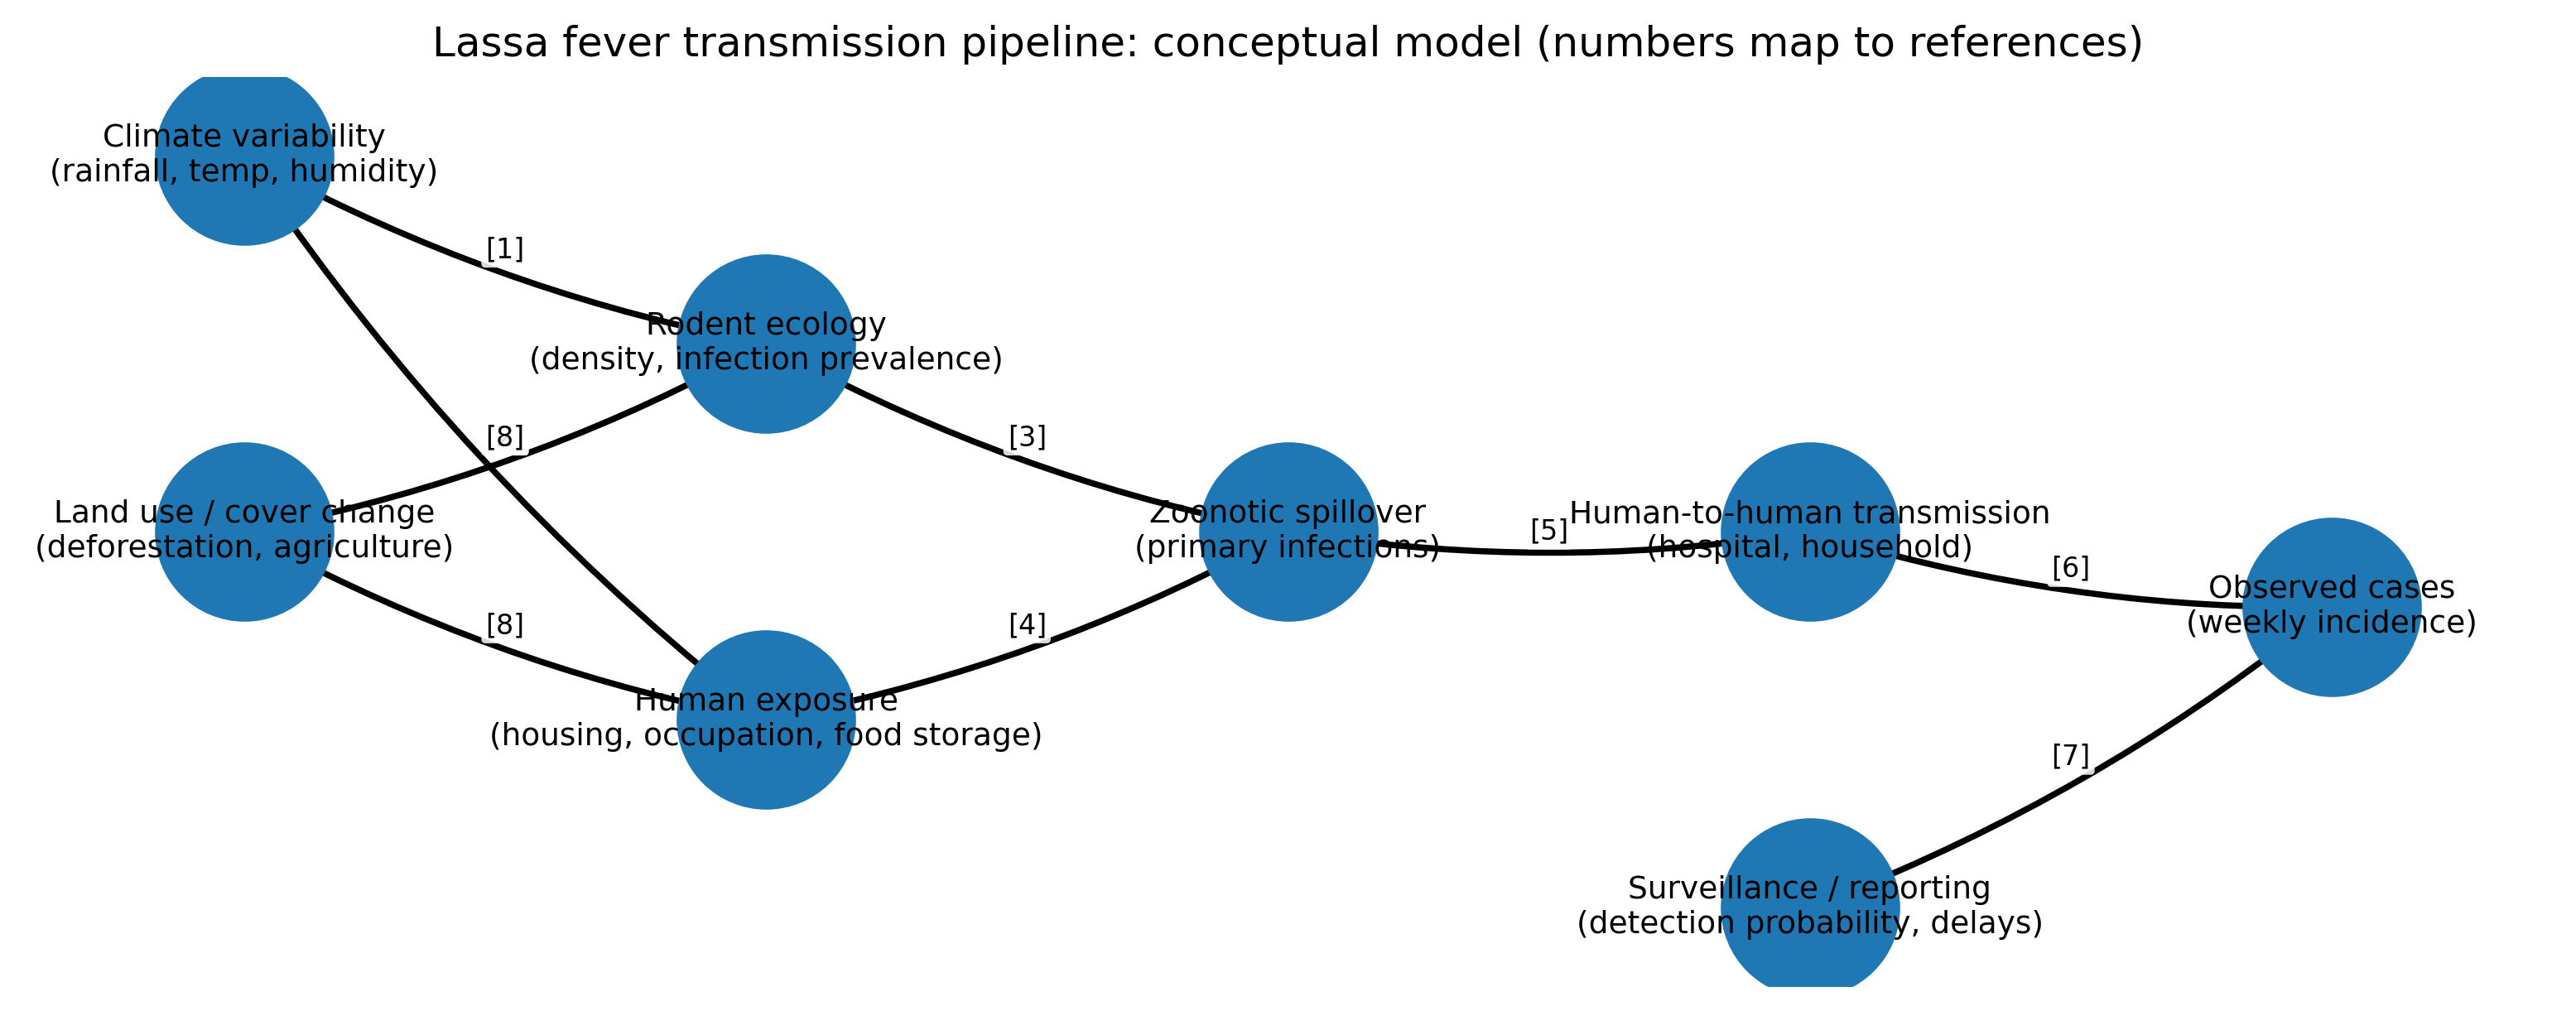

In [34]:
build_all_figures()

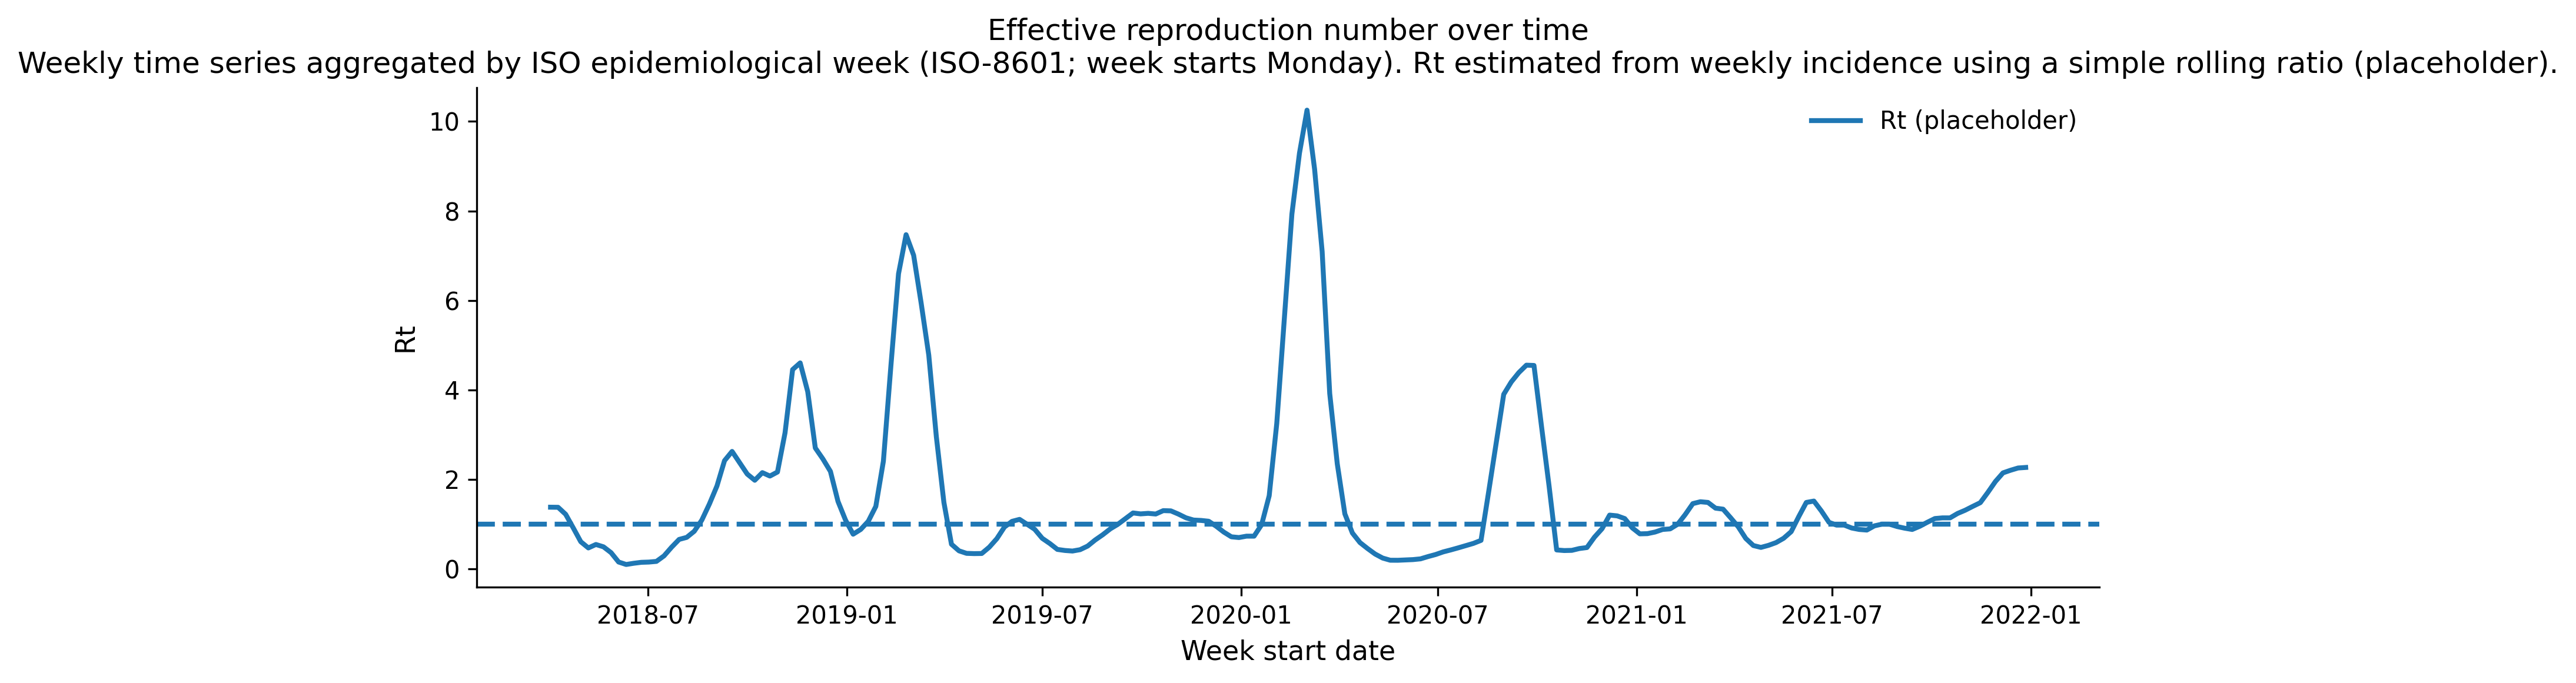

PosixPath('../reports/figures/fig_rt_data_proof.png')

In [31]:
# ===== MINIMUM PROOF OF DATA CONNECTION =====

# 1. Load data
df_panel = pd.read_csv("../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv")

# 2. Aggregate to national weekly
df_nat = (
    df_panel
    .groupby(["year", "week"], as_index=False)
    .agg(cases_obs=("cases", "sum"))
)

# 3. Generate a data-driven figure
cfg = FigConfig(outdir=Path("../reports/figures"), fmt="png", dpi=300)

fig_rt_over_time(
    cfg,
    df_nat,
    year_col="year",
    week_col="week",
    obs_col="cases_obs",
    name="fig_rt_data_proof",
    show=True
)


In [26]:
df_nat = (
    df_panel
    .groupby("week", as_index=False)
    .agg(
        cases_obs=("cases", "sum"),
        rain_mm=("rain_mm", "mean"),
        temp_c=("temp_c", "mean"),
    )
    .sort_values("week")
)

df_nat.head()


,week,cases_obs,rain_mm,temp_c
0,1,33,0.838406,25.294092
1,2,44,1.964351,26.109550
2,3,33,1.585060,26.242343
3,4,116,2.900080,26.592415
4,5,123,3.930961,26.828472


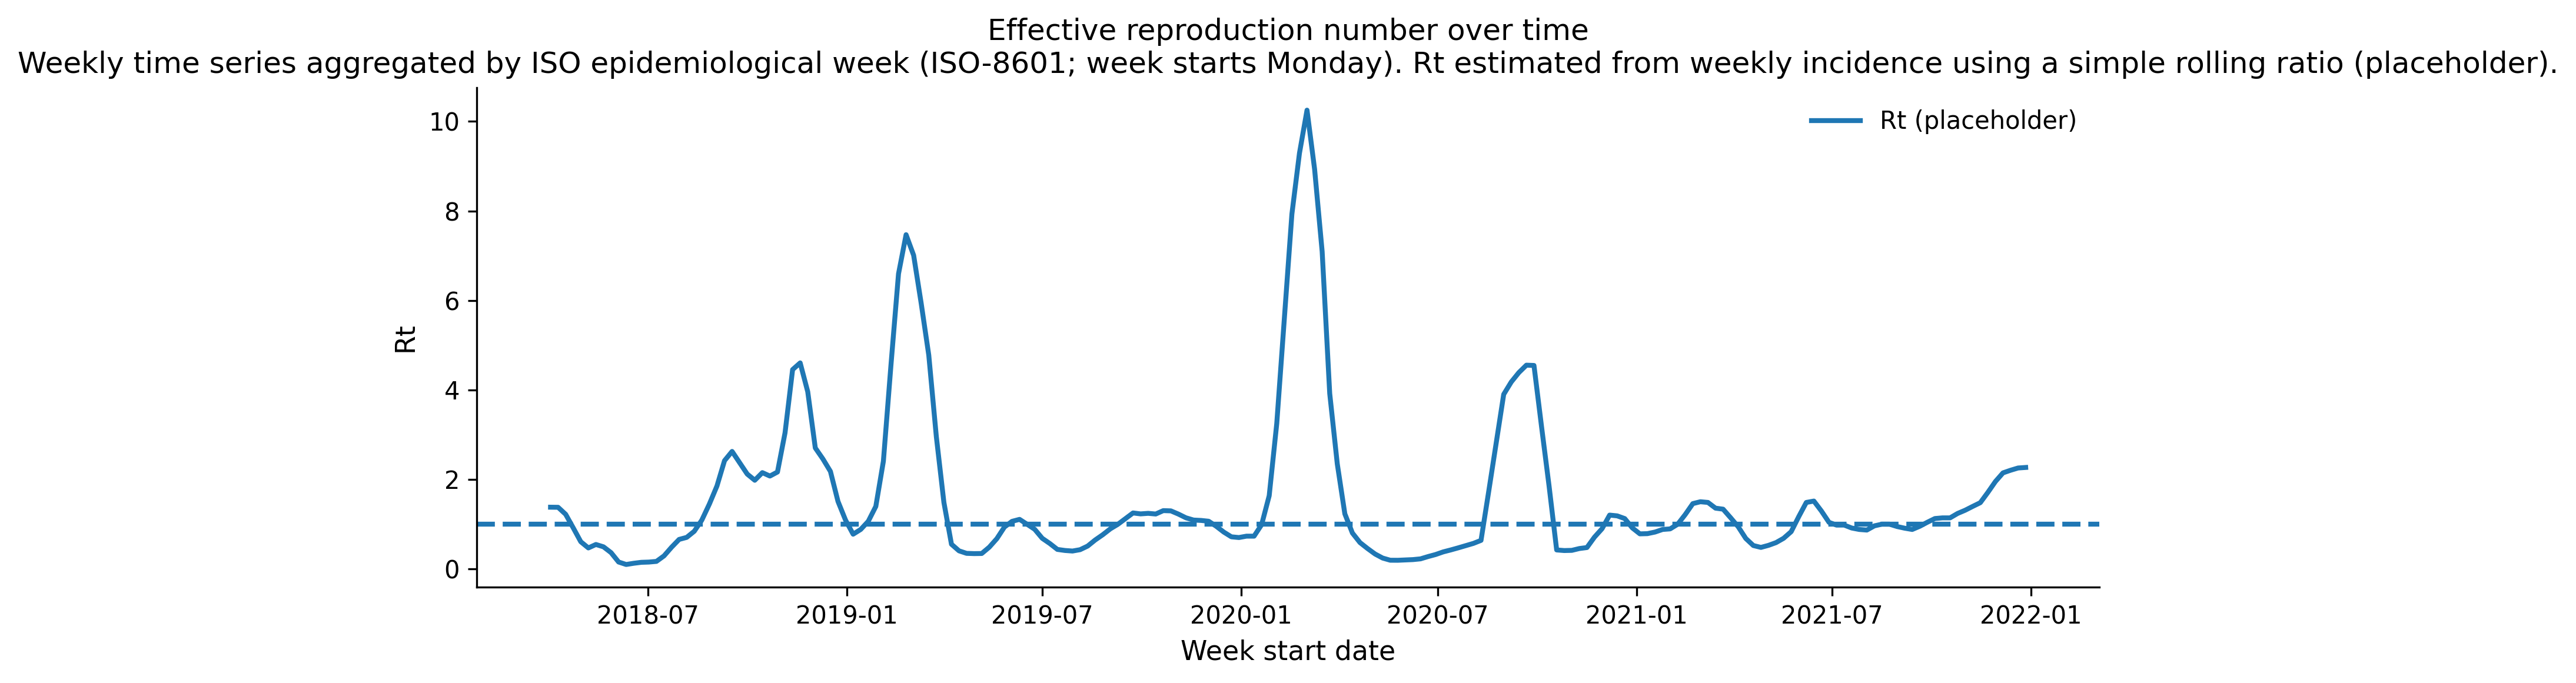

PosixPath('../reports/figures/fig3_rt_over_time.png')

In [32]:
cfg = FigConfig(outdir=Path("../reports/figures"), fmt="png", dpi=300)

fig_rt_over_time(cfg, df_nat, date_col="date", obs_col="cases_obs")
